In [1]:
%matplotlib inline
import os 
from subprocess import check_call

import numpy as np
import xarray as xr
import xesmf as xe

USER = os.environ['USER']

## the CESM2 defaults for prescibed aerosol forcing

In [2]:
inputdata = '/glade/p/cesmdata/cseg/inputdata'
presaero_path = f'{inputdata}/atm/cam/chem/trop_mozart_aero/aero'
presaero_file = 'aerosoldep_WACCM.ensmean_monthly_hist_1849-2015_0.9x1.25_CMIP6_c180926.nc'
ds = xr.open_dataset(f'{presaero_path}/{presaero_file}',decode_times=False,decode_coords=False)
ds

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, ntb: 2, time: 2004)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) float64 15.5 45.0 74.5 ... 6.088e+04 6.091e+04 6.094e+04
Dimensions without coordinates: ntb
Data variables:
    BCDEPWET   (time, lat, lon) float32 ...
    BCPHIDRY   (time, lat, lon) float32 ...
    BCPHODRY   (time, lat, lon) float32 ...
    DSTX01DD   (time, lat, lon) float32 ...
    DSTX01WD   (time, lat, lon) float32 ...
    DSTX02DD   (time, lat, lon) float32 ...
    DSTX02WD   (time, lat, lon) float32 ...
    DSTX03DD   (time, lat, lon) float32 ...
    DSTX03WD   (time, lat, lon) float32 ...
    DSTX04DD   (time, lat, lon) float32 ...
    DSTX04WD   (time, lat, lon) float32 ...
    OCDEPWET   (time, lat, lon) float32 ...
    OCPHIDRY   (time, lat, lon) float32 ...
    OCPHODRY   (time, lat, lon) float32 ...
    date   

In [3]:
ds.DSTX04WD

<xarray.DataArray 'DSTX04WD' (time: 2004, lat: 192, lon: 288)>
[110813184 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) float64 15.5 45.0 74.5 ... 6.088e+04 6.091e+04 6.094e+04
Attributes:
    units:         kg m-2 s-1
    long_name:     Dust wet deposition flux (size 4)
    cell_methods:  time: mean

## add field `EXTTERFE`

`data/waccm_carma_unab_43tpd_fe_wetdep_rate.nc` contains the climatological field of Fe wet deposition flux rate at surface from the WACCM/CARMA model simulation integrate at a horizontal resolution of 1.9x2.4 degree. The data is averaged from 2004-2014 from Brooks et al.(2017)'s output.  


James Brooke, Wuhu Feng, Juan Diego Carrillo-Sanchez, Graham Mann, Alexander James, Charles Bardeen, John Plane, Meteoric smoke deposition in the polar regions: a comparison of measurements with global atmospheric models, J. Geophys. Res. Atmos., 122, https://doi.org/10.1002/2017JD027143, 2017.

In [4]:
extterfe_path = './data'
extterfe_file = 'waccm_carma_unab_43tpd_fe_wetdep_rate.nc'
dsf = xr.open_dataset(f'{extterfe_path}/{extterfe_file}',decode_coords=False,decode_times=False)
dsf

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, plev: 1, time: 12)
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0
  * plev     (plev) float32 1000.0
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
Data variables:
    dustsw   (time, plev, lat, lon) float64 ...
Attributes:
    institution:    University of Leeds, UK
    source:         WACCM/CARMA
    project_id:     EU CODITA
    experiment_id:  Brooke et al. (JGR, 2017), unab-43 (35.4 t d−1 unablated ...
    contact:        Wuhu Feng and John Plane (w.feng@leeds.ac.uk and J.M.C.Pl...

In [5]:
dsf.dustsw

<xarray.DataArray 'dustsw' (time: 12, plev: 1, lat: 96, lon: 144)>
[165888 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0
  * plev     (plev) float32 1000.0
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
Attributes:
    long_name:      Fe wet deposition flux rate
    units:          umol Fe m-2/yr
    standard_name:  dustsw

# convert from umol Fe m-2/yr to kg/m^2/s

In [6]:
mw_fe = 55.845
umolm2yr_to_kgm2s = mw_fe * 1e-6 * 1e-3 / 86400. / 365. # (mw g/mol)(1mol/10^6 umol)(1kg/10^3g)(1y/365d)(1d/86400s)
dsf['EXTTERFE'] = dsf.dustsw.isel(plev=0) * umolm2yr_to_kgm2s
dsf.EXTTERFE.attrs['units'] = 'kg m-2 s-1'
dsf.EXTTERFE.attrs['long_name'] = 'Fe deposition rate'
dsf.EXTTERFE.attrs['cell_methods'] = 'time: mean'
dsf.EXTTERFE.encoding = dsf.dustsw.encoding
dsf

<xarray.Dataset>
Dimensions:   (lat: 96, lon: 144, plev: 1, time: 12)
Coordinates:
  * lon       (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat       (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0
  * plev      (plev) float32 1000.0
  * time      (time) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
Data variables:
    dustsw    (time, plev, lat, lon) float64 ...
    EXTTERFE  (time, lat, lon) float64 1.1e-17 1.1e-17 ... 7.517e-17 7.517e-17
Attributes:
    institution:    University of Leeds, UK
    source:         WACCM/CARMA
    project_id:     EU CODITA
    experiment_id:  Brooke et al. (JGR, 2017), unab-43 (35.4 t d−1 unablated ...
    contact:        Wuhu Feng and John Plane (w.feng@leeds.ac.uk and J.M.C.Pl...

## regrid to f09

In [7]:
variable = 'EXTTERFE'

weight_file_dir = f'/glade/work/mclong/regrid_xesmf/weight_files'
if not os.path.exists(weight_file_dir):
    call(['mkdir','-p',weight_file_dir])

#-- setup regridding
grid_src = 'f19'
grid_dst = 'f09'    

method = 'bilinear'
weight_file = f'{weight_file_dir}/{method}_{grid_src}_to_{grid_dst}.nc'

regridder = xe.Regridder(dsf,ds.drop([v for v in ds.variables if v not in ['lat','lon']]),method=method,filename=weight_file,
                         periodic=True,reuse_weights=True)

#-- define output dataset
dao = regridder(dsf[variable])
dao

Reuse existing file: /glade/work/mclong/regrid_xesmf/weight_files/bilinear_f19_to_f09.nc


<xarray.DataArray 'EXTTERFE' (time: 12, lat: 192, lon: 288)>
array([[[1.100436e-17, 1.100461e-17, ..., 1.100534e-17, 1.100512e-17],
        [1.333261e-17, 1.338158e-17, ..., 1.303106e-17, 1.318235e-17],
        ...,
        [2.019199e-16, 2.132006e-16, ..., 1.964860e-16, 1.992181e-16],
        [1.355597e-16, 1.355597e-16, ..., 1.355597e-16, 1.355597e-16]],

       [[3.675852e-17, 3.675852e-17, ..., 3.675852e-17, 3.675852e-17],
        [4.230648e-17, 4.287169e-17, ..., 4.053528e-17, 4.142199e-17],
        ...,
        [4.718203e-16, 5.181096e-16, ..., 1.828487e-16, 3.273951e-16],
        [7.254449e-17, 7.254449e-17, ..., 7.254449e-17, 7.254449e-17]],

       ...,

       [[8.706413e-17, 8.706413e-17, ..., 8.706413e-17, 8.706413e-17],
        [8.930507e-17, 7.744763e-17, ..., 6.863186e-17, 7.896654e-17],
        ...,
        [6.970446e-17, 6.802341e-17, ..., 6.924107e-17, 6.947272e-17],
        [6.968523e-17, 6.968523e-17, ..., 6.968523e-17, 6.968523e-17]],

       [[1.948454e-17, 1.9486

Check regridding

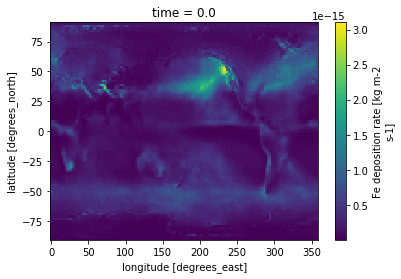

In [8]:
dsf.EXTTERFE.isel(time=0).plot()

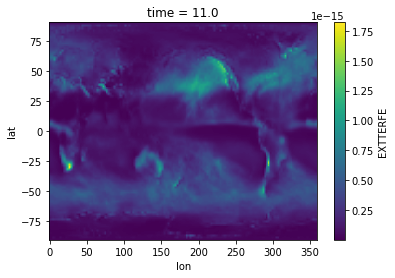

In [9]:
dao.isel(time=11).plot()

In [10]:
ds['EXTTERFE'] = xr.full_like(ds.DSTX01DD,fill_value=0.)
nyear = int(len(ds.time)/12)
for i in range(nyear):
    nx = np.arange(i*12,i*12+12,1)
    ds.EXTTERFE.values[nx,:,:] = dao.values
ds.EXTTERFE.attrs = dsf.EXTTERFE.attrs

ds.EXTTERFE.encoding['_FillValue'] = 1e30

ds.attrs['extterfe_comment'] = f'Extraterrestrial Fe dep added by Matt Long (NCAR) from {extterfe_file}'
ds.info()

xarray.Dataset {
dimensions:
	lat = 192 ;
	lon = 288 ;
	ntb = 2 ;
	time = 2004 ;

variables:
	float32 BCDEPWET(time, lat, lon) ;
		BCDEPWET:units = kg m-2 s-1 ;
		BCDEPWET:long_name = Hydrophylic black carbon wet deposition flux ;
		BCDEPWET:cell_methods = time: mean ;
	float32 BCPHIDRY(time, lat, lon) ;
		BCPHIDRY:units = kg m-2 s-1 ;
		BCPHIDRY:long_name = Hydrophylic black carbon dry deposition flux ;
		BCPHIDRY:cell_methods = time: mean ;
	float32 BCPHODRY(time, lat, lon) ;
		BCPHODRY:units = kg m-2 s-1 ;
		BCPHODRY:long_name = Hydrophobic black carbon dry deposition flux ;
		BCPHODRY:cell_methods = time: mean ;
	float32 DSTX01DD(time, lat, lon) ;
		DSTX01DD:units = kg m-2 s-1 ;
		DSTX01DD:long_name = Dust dry deposition flux (size 1) ;
		DSTX01DD:cell_methods = time: mean ;
	float32 DSTX01WD(time, lat, lon) ;
		DSTX01WD:units = kg m-2 s-1 ;
		DSTX01WD:long_name = Dust wet deposition flux (size 1) ;
		DSTX01WD:cell_methods = time: mean ;
	float32 DSTX02DD(time, lat, lon) ;
		DSTX02

In [20]:
file_out_path = '/glade/work/mclong/cesm_cases/xtfe/data/forcing'
os.makedirs(file_out_path, exist_ok=True)

file_out_file = presaero_file.replace('.nc', '-xtfe.nc')

ds.to_netcdf(f'{file_out_path}/{file_out_file}')
        
print('run the following command:')
print('./nc4_to_nc3.py', f'{file_out_path}/{file_out_file}')

run the following command:
./nc4_to_nc3.py /glade/work/mclong/cesm_cases/xtfe/data/forcing/aerosoldep_WACCM.ensmean_monthly_hist_1849-2015_0.9x1.25_CMIP6_c180926-xtfe.nc
